In [1]:
pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 47.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=d6edc576051d1f13192549c9e7513ec14fe36d6671e96f52cab857a62207112a
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [2]:
pip install bottleneck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 6.2 MB/s eta 0:00:00


In [3]:
#ライブラリをインポート
import os #OSに依存する様々な機能を利用するためのモジュール(ファイルやディレクトリ操作など)
import re #正規表現を利用するためのモジュール
import csv  #csvファイルを扱うためのモジュール
import statistics #数学的計算のためのモジュール
import math #数学的計算のためのモジュール
from decimal import Decimal #小数点桁落ちをなくすためのモジュール
import matplotlib.pyplot as plt #グラフ描画のためのモジュール
import japanize_matplotlib #グラフ描画に日本語を用いるためのモジュール
import numpy as np  #多次元配列計算のためのモジュール
import bottleneck as bn #移動平均計算のためのモジュール
import pandas as pd #データフレームを扱うためのモジュール
from scipy import signal  #信号処理のためのモジュール
from scipy.stats import skew, kurtosis  #歪度と尖度を調べるためのモジュール
from sklearn.model_selection import train_test_split  #データをトレーニング用とテスト用に分けるためのモジュール
from sklearn import preprocessing #データを正規化するためのモジュール
from sklearn.preprocessing import StandardScaler  #データを標準化するためのモジュール
from sklearn.preprocessing import LabelEncoder  #カテゴリ変数を数値化するためのモジュール
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score #機械学習モデルの性能評価のためのモジュール
import tensorflow as tf #TensorFlow(Googleが開発したオープンソースの機械学習フレームワーク)
from tensorflow import keras  #TensorFlow用のニューラルネットワークライブラリAPI
from tensorflow.keras import layers #ニューラルネットワークのレイヤーを定義するためのモジュール

In [4]:
#Google colab用
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#GPUを使うためのコマンド
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
#よく使うgit command

#google colabと揃える
#git fetch origin main
#git reset --hard origin/main

In [6]:
#定数を定義
BINS = 4000  #ヒストグラムのビンの数
EPSILON = .00001  #スムージングパラメータ
UPPER_LIMIT = 1.1 #静止区間の上限
LOWER_LIMIT = 0.9 #静止区間の加減
STATIONARY_INTERVALS = 5  #静止区間除去のサンプルの間隔(静止区間が何サンプル連続したら除去するか)
TRAIN_SIZE = 0.8  #機械学習のトレーニングデータの割合

#transformer regression
#各種パラメータ
NUM_HEADS = 8
KEY_DIM = 500
DROPOUT = 0.1
N = 1 #Encoderのレイヤー

In [7]:
#Hascの加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[1]))
            AccY.append(float(row[2]))
            AccZ.append(float(row[3]))

    return AccX, AccY, AccZ

In [8]:
#加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration2(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[2]))
            AccY.append(float(row[3]))
            AccZ.append(float(row[4]))

    return AccX, AccY, AccZ

In [9]:
#3軸合成加速度を計算する関数
def acc_to_resultant(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める
    return ResultantAcc

In [10]:
#静止区間を除去する関数(STATIONARY_INTERVALS分のみ)
def acc_to_remove_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
            if counter == STATIONARY_INTERVALS: #カウントがSTATIONARY_INTERVALSに達したらその区間を削除
                del ResultantAcc[i+1-STATIONARY_INTERVALS:i+1]    #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
        else:
            counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [11]:
#静止区間を除去する関数(STATIONARY_INTERVALS以上続いた静止区間全て)
def acc_to_remove_all_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
        else:
            if counter >= STATIONARY_INTERVALS:
                del ResultantAcc[i+1-counter:i+1]   #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
            else :
                counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [12]:
#連続する2サンプルの差分を取る関数
def calculate_differences_of_acceleration(ResultantAcc: list[float]) -> list[float]:
    DifferenceAcc = [math.fabs(Decimal(ResultantAcc[i + 1]) - Decimal(ResultantAcc[i])) for i in range(len(ResultantAcc) - 1)]  #連続する2サンプルの誤差を取る
    return DifferenceAcc

In [13]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が各加速度の差分データの最小値〜最大値）
def create_histogram(DifferenceAcc_list: list[float]) -> np.histogram:
    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)
    for i in range(len(DifferenceAcc_list)):
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, density=True) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [14]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が全加速度の差分データの中の最小値〜最大値）
def create_histogram2(DifferenceAcc_list: list[float]) -> np.histogram:
    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)
    min_value = min(min(row) for row in DifferenceAcc_list)
    max_value = max(max(row) for row in DifferenceAcc_list)
    for i in range(len(DifferenceAcc_list)):
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [15]:
#各加速度データをダウンサンプリングする関数
def resampling_Acc(originHz: int, newHz: int, AccX: list[float], AccY: list[float], AccZ: list[float], Hz: np.array) -> tuple[list[float], list[float], list[float], np.array]:
    i = 0   #カウンター変数

    while (Hz[i] == originHz):
        originlen = len(AccX[i])    #元々のデータの長さ
        sampling_factor = int(originlen * (newHz/originHz)) #ダウンサンプリングした後のデータの長さ
        newAccX = signal.resample(AccX[i], sampling_factor)    #データをダウンサンプリング
        newAccY = signal.resample(AccY[i], sampling_factor)    #データをダウンサンプリング
        newAccZ = signal.resample(AccZ[i], sampling_factor)    #データをダウンサンプリング
        AccX.append(newAccX)   #ダウンサンプリングデータを加速度データに追加
        AccY.append(newAccY)   #ダウンサンプリングデータを加速度データに追加
        AccZ.append(newAccZ)   #ダウンサンプリングデータを加速度データに追加
        Hz = np.append(Hz, newHz)   #ダウンサンプリングレートを追加
        i += 1

    return AccX, AccY, AccZ, Hz

In [16]:
#My Transformer Model
def Transformer_Encoder_B():
      # Define the input shape
      input_shape = (BINS,)
      output_shape = (1,)

      #形を定義(このモジュールは行列でないとダメっぽい)
      inputs_encoder = layers.Input(shape=input_shape)
      #inputs_decoder = layers.Input(shape=output_shape)

      #Encoderに対する入力の形状
      x_encoder = layers.Reshape((10, 400))(inputs_encoder)

      #Transformer Encoder Layer(BERT)
      for i in range(N):
            #Multi-Head-Attention Layer
            attention_encoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, x_encoder)

            #Dropout Layer
            attention_encoder = layers.Dropout(rate=DROPOUT)(attention_encoder)
            #Add & Norm Layer
            attention_encoder = layers.LayerNormalization()(x_encoder + attention_encoder)

            #Feed-Forward-Network
            ffn_encoder = layers.Dense(400 * 4, use_bias=True, activation="relu")(attention_encoder)
            ffn_encoder = layers.Dense(400, use_bias=True)(ffn_encoder)

            #Dropout Layer
            ffn_encoder = layers.Dropout(rate=DROPOUT)(ffn_encoder)
            #Add & Norm Layer
            x_encoder = layers.LayerNormalization()(attention_encoder + ffn_encoder)

      x = layers.Flatten()(x_encoder)
      x = layers.Dense(128, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      x = layers.Dense(64, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      outputs = layers.Dense(1, activation="relu")(x)

      model = keras.Model(inputs=inputs_encoder, outputs=outputs)

      # Compile the model
      model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.mean_squared_error,
            metrics=[keras.metrics.mean_squared_error],
      )

      return model

In [17]:
#My Transformer Model
def Transformer_Encoder_S():
      # Define the input shape
      input_shape = (BINS,)
      output_shape = (1,)

      #形を定義(このモジュールは行列でないとダメっぽい)
      inputs_encoder = layers.Input(shape=input_shape)
      #inputs_decoder = layers.Input(shape=output_shape)

      #Encoderに対する入力の形状
      x_encoder = layers.Reshape((1, 100))(inputs_encoder)

      #Transformer Encoder Layer(BERT)
      for i in range(N):
            #Multi-Head-Attention Layer
            attention_encoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, x_encoder)

            #Dropout Layer
            attention_encoder = layers.Dropout(rate=DROPOUT)(attention_encoder)
            #Add & Norm Layer
            attention_encoder = layers.LayerNormalization()(x_encoder + attention_encoder)

            #Feed-Forward-Network
            ffn_encoder = layers.Dense(BINS * 4, use_bias=True, activation="relu")(attention_encoder)
            ffn_encoder = layers.Dense(BINS, use_bias=True)(ffn_encoder)

            #Dropout Layer
            ffn_encoder = layers.Dropout(rate=DROPOUT)(ffn_encoder)
            #Add & Norm Layer
            x_encoder = layers.LayerNormalization()(attention_encoder + ffn_encoder)

      x = layers.Flatten()(x_encoder)
      x = layers.Dense(32, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      x = layers.Dense(16, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      outputs = layers.Dense(1, activation="relu")(x)

      model = keras.Model(inputs=inputs_encoder, outputs=outputs)

      # Compile the model
      model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.mean_squared_error,
            metrics=[keras.metrics.mean_squared_error],
      )

      return model

In [78]:
#path(サンプリング周波数100Hzのデータ)から加速度の差分値, ヒストグラム, 正解ラベルを返す関数
def path_to_histogram(path: str) -> tuple[list[float], np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    #静止区間を除去
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)

    return DifferenceAcc_list, DifferenceAcc_hist, Hz

In [79]:
#path(サンプリング周波数100Hzのデータ)から様々な特徴量と正解ラベルを返す関数
def path_to_features(path: str) -> tuple[np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    features = np.ones((len(Hz), 8))    #各特徴量を入れる変数でこの関数の返り値

    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_resultant(AccX[i], AccY[i], AccZ[i]))
        features[i][0] = np.var(ResultantAcc[i])   #静止区間を除去する前の合成加速度の分散値を0列目に格納
        features[i][1] = len(ResultantAcc[i])   #静止区間を除去する前のデータの長さを1列目に格納

    #静止区間を除去
    ResultantAcc = []
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    for i in range(len(Hz)):
      features[i][2] = np.var(ResultantAcc[i])   #静止区間を除去した後の合成加速度の分散値を2列目に格納
      features[i][3] = len(ResultantAcc[i])   #静止区間を除去した後のデータの長さを3列目に格納

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)


    for i in range(len(Hz)):
      features[i][4] = kurtosis(DifferenceAcc_hist[i])  #標準化前のヒストグラムの尖度を4列目に格納
      features[i][5] = skew(DifferenceAcc_hist[i])  #標準化前のヒストグラムの歪度を5列目に格納

    #標準化
    scaler = StandardScaler()
    # Fit the scaler to x_train
    scaler.fit(DifferenceAcc_hist)
    # Use the scaler to transform x_train and x_test
    DifferenceAcc_hist = scaler.transform(DifferenceAcc_hist)

    for i in range(len(Hz)):
      features[i][6] = kurtosis(DifferenceAcc_hist[i])  #標準化後のヒストグラムの尖度を6列目に格納
      features[i][7] = skew(DifferenceAcc_hist[i])  #標準化後のヒストグラムの歪度を7列目に格納

    return features, Hz

In [20]:
BINS = 100

In [ ]:
DifferenceAcc_list, DifferenceAcc_hist, Hz = path_to_histogram("/content/drive/MyDrive/my_walk_data(100Hz15minutes)/")

In [80]:
DifferenceAcc_listW, DifferenceAcc_histW, HzW = path_to_histogram("/content/drive/MyDrive/hasc(walk)/")

In [81]:
DifferenceAcc_listJ, DifferenceAcc_histJ, HzJ = path_to_histogram("/content/drive/MyDrive/hasc(jog)/")

In [82]:
FeaturesW, HzW = path_to_features("/content/drive/MyDrive/hasc(walk)/")

In [83]:
FeaturesJ, HzJ = path_to_features("/content/drive/MyDrive/hasc(jog)/")

In [84]:
root_var = np.sqrt(FeaturesW[:, 1])

In [85]:
root_var2 = np.sqrt(FeaturesJ[:, 1])

In [89]:
rvarskew = (FeaturesW[:, 5] * root_var)

In [90]:
rvarskew2 = (FeaturesJ[:, 5] * root_var2)

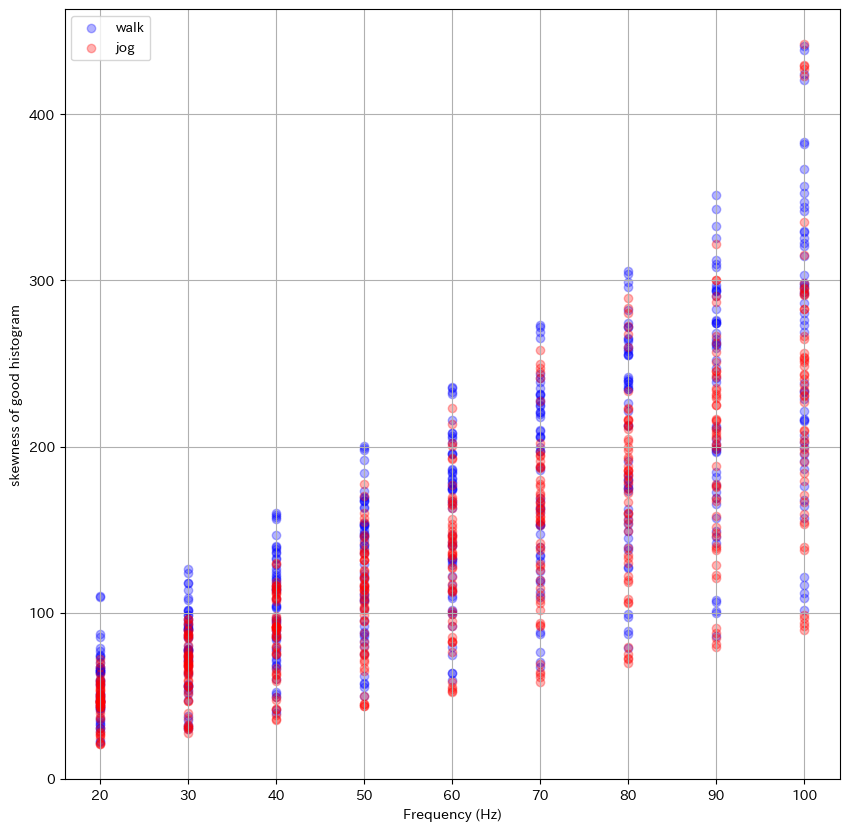

In [91]:
# クラスごとに色分けされたプロットを作成
plt.figure(figsize=(10, 10))
#plt.scatter(HzW, FeaturesW[:, 5], alpha=0.3, c="b", label="walk")
#plt.scatter(HzJ, FeaturesJ[:, 5], alpha=0.3, c="r", label="jog")
#plt.scatter(HzW, root_var, alpha=0.3, c="b", label="walk")
#plt.scatter(HzJ, root_var2, alpha=0.3, c="r", label="jog")
#plt.scatter(HzW, mmax, alpha=0.3, c="b", label="walk")
#plt.scatter(HzJ, mmax2, alpha=0.3, c="r", label="jog")
plt.scatter(HzW, rvarskew, alpha=0.3, c="b", label="walk")
plt.scatter(HzJ, rvarskew2, alpha=0.3, c="r", label="jog")
#plt.colorbar(label='Frequency (Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('skewness of good histogram')
#plt.ylim(-0.5, 4.5)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す
ax1.hist(DifferenceAcc_list[0], bins=BINS, density=True, range=(0, 6000), label="100 Hz")
ax2.hist(DifferenceAcc_list[120], bins=BINS,density=True, range=(0, 6000), label="50 Hz")
ax3.hist(DifferenceAcc_list[192], bins=BINS,density=True, range=(0, 6000), label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 0.0020)
ax2.set_ylim(0, 0.0020)
ax3.set_ylim(0, 0.0020)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [ ]:
pathHascJog = "/content/drive/MyDrive/hasc(jog)/"
filename = os.listdir(pathHascJog) #引数のパスのディレクトリの中のファイル名一覧を取得
#filename.remove(".DS_Store")

In [ ]:
#使う変数を宣言
readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み二次元配列に格納
for i in filename:
    readAccX, readAccY, readAccZ = get_acceleration(pathHascJog+i)
    AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

HzHascJog = np.ones(len(filename)) * 100

#各加速度データをダウンサンプリング
for i in range(9, 1, -1):
    AccX, AccY, AccZ, HzHascJog = resampling_Acc(100, i * 10, AccX, AccY, AccZ, HzHascJog)

#静止区間を除去
for i in range(len(HzHascJog)):
    ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_histHascJog = create_histogram(DifferenceAcc_list)

In [ ]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す(範囲指定)
ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, range=(0, 1), label="100 Hz")
ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, range=(0, 1), label="50 Hz")
ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, range=(0, 1), label="20 Hz")

#各subplot領域にデータを渡す
#ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, label="100 Hz")
#ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, label="50 Hz")
#ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [92]:
DifferenceAcc_histW = DifferenceAcc_histW / root_var

ValueError: ignored

In [ ]:
stdsc = StandardScaler()
DifferenceAcc_hist = stdsc.fit_transform(DifferenceAcc_hist)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, test_size = 0.2, random_state=123)

In [ ]:
stdsc = StandardScaler()
# 注意
# 訓練用のデータを標準化
X_train = stdsc.fit_transform(X_train)
# 訓練用データを基準にテストデータも標準化
X_test = stdsc.transform(X_test)

In [ ]:
model = Transformer_Encoder_B()

In [ ]:
mae = []

In [ ]:
for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, test_size = 0.2, random_state=123)
  model.fit(X_train, y_train, batch_size=16, epochs=300, shuffle=True, validation_split=0.2)
  y_pred = tf.cast(tf.clip_by_value(model.predict(X_test), 20, 100), tf.int32)
  mae.append(mean_absolute_error(y_pred, y_test))
mae